In [38]:
import pandas as pd
from constants import base_path
import matplotlib.pyplot as plt
import numpy as np
import json
import ast
from collections import Counter

In [39]:
diagnosis_df_valid = pd.read_csv(f"{base_path}\\input\\release_validate_patients")

In [40]:
with open(f"{base_path}\\input\\release_evidences.json") as f:
  evidences = json.load(f)
evidences_list = []
evidences_dict = {}
evidences_en_to_code = {}
for e in evidences.keys():
  # only binary symptoms and no antecedents
  if (not evidences[e]["possible-values"]) and (not evidences[e]["is_antecedent"]):
    evidences_list.append(e)
    evidences_dict[e] = evidences[e]["question_en"]
    evidences_en_to_code[evidences[e]["question_en"]] = e
evidences_code_to_en = evidences_dict
evidences_list_en = list(evidences_en_to_code.keys())

In [41]:
with open(f"{base_path}\\input\\release_conditions.json") as f:
  disease_dict = json.load(f)
disease_list = list(disease_dict.keys())

In [42]:
def get_misses(degraded_df):
    missed_evidences_per_disease = {}
    for disease in disease_list:
        disease_df = degraded_df[degraded_df["PATHOLOGY"]==disease]

        # here, we want to count the most missed evidence per disease
        missed_evidences = []
        for e in disease_df["missed_evidence"]:
            e = ast.literal_eval(e)
            if e:
                missed_evidences.extend(e)
        missed_evidences_dict = dict(Counter(missed_evidences).most_common(10))
        missed_evidences_dict = {evidences_code_to_en[k]:missed_evidences_dict[k] for k in missed_evidences_dict}

        # hypothesis: the initial evidence is not very specific, hence the degrade in predictions
        initial_evidences_dict = dict(Counter(list(disease_df["INITIAL_EVIDENCE"])).most_common(10))
        initial_evidences_dict = {
            evidences_code_to_en[k]: initial_evidences_dict[k]
            for k in initial_evidences_dict}
        missed_evidences_per_disease[disease] = {
            "top_missed_evidences": missed_evidences_dict,
            "initial_evidences_count": initial_evidences_dict
        }
    return missed_evidences_per_disease

In [43]:
valid_df_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\questionnaire_df.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

## Random Forest

In [44]:
valid_df_pred = pd.read_csv(f"{base_path}\\output\\error_analysis\\validation_df_all_patients.csv", index_col=False).drop(["Unnamed: 0"], axis=1)
valid_df_pred_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\validation_df_all_patients_questionnaire.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

In [45]:
valid_df_pred = valid_df_pred[["PATHOLOGY", "predicted_diagnosis", "is_matched"]]
valid_df_pred

,PATHOLOGY,predicted_diagnosis,is_matched
0,Anemia,['Anemia'],True
1,Panic attack,['Panic attack'],True
2,Influenza,['Influenza'],True
3,Anemia,['Anemia'],True
4,Boerhaave,['Boerhaave'],True
...,...,...,...
132443,Viral pharyngitis,['Acute otitis media'],False
132444,Acute pulmonary edema,['Acute pulmonary edema'],True
132445,GERD,['GERD'],True
132446,Epiglottitis,['Epiglottitis'],True


In [46]:
valid_df_pred_questionnaire = valid_df_pred_questionnaire[["predicted_diagnosis", "is_matched", "hit_rate"]]
valid_df_pred_questionnaire

,predicted_diagnosis,is_matched,hit_rate
0,['Anemia'],True,1.0
1,['Panic attack'],True,1.0
2,['Influenza'],True,1.0
3,['Anemia'],True,1.0
4,['Boerhaave'],True,1.0
...,...,...,...
132443,['Acute otitis media'],False,1.0
132444,['Acute pulmonary edema'],True,1.0
132445,['GERD'],True,1.0
132446,['Epiglottitis'],True,0.8


In [47]:
match_df = valid_df_pred.join(valid_df_pred_questionnaire.add_suffix("_questionnaire"))
match_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire
0,Anemia,['Anemia'],True,['Anemia'],True,1.0
1,Panic attack,['Panic attack'],True,['Panic attack'],True,1.0
2,Influenza,['Influenza'],True,['Influenza'],True,1.0
3,Anemia,['Anemia'],True,['Anemia'],True,1.0
4,Boerhaave,['Boerhaave'],True,['Boerhaave'],True,1.0
...,...,...,...,...,...,...
132443,Viral pharyngitis,['Acute otitis media'],False,['Acute otitis media'],False,1.0
132444,Acute pulmonary edema,['Acute pulmonary edema'],True,['Acute pulmonary edema'],True,1.0
132445,GERD,['GERD'],True,['GERD'],True,1.0
132446,Epiglottitis,['Epiglottitis'],True,['Epiglottitis'],True,0.8


In [48]:
pd.crosstab(index=match_df['is_matched'], columns=match_df['is_matched_questionnaire'])
# 11746 degraded predictions, 20 questions. previously correctly diagnosed but misdiagnosed using the questionnaire
# 2583 for 30 questions

is_matched_questionnaire,False,True
is_matched,,
False,12596,0
True,2583,117269


In [49]:
degraded_df = match_df[(match_df['is_matched']==True) & (match_df['is_matched_questionnaire']==False)]

In [50]:
np.mean(degraded_df["hit_rate_questionnaire"])
# degraded predictions has low questionnaire hit rate, meaning for degraded predictions, relevant symptoms were not asked.

0.5228020205372123

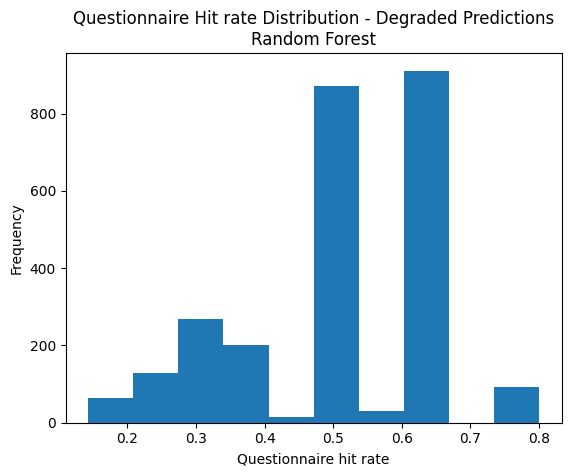

In [51]:
degraded_df["hit_rate_questionnaire"].plot.hist()
plt.title("Questionnaire Hit rate Distribution - Degraded Predictions\nRandom Forest")
plt.xlabel("Questionnaire hit rate")
plt.savefig(f'{base_path}\\output\\questionnaire\\hit_rate_degraded.jpg', bbox_inches='tight')

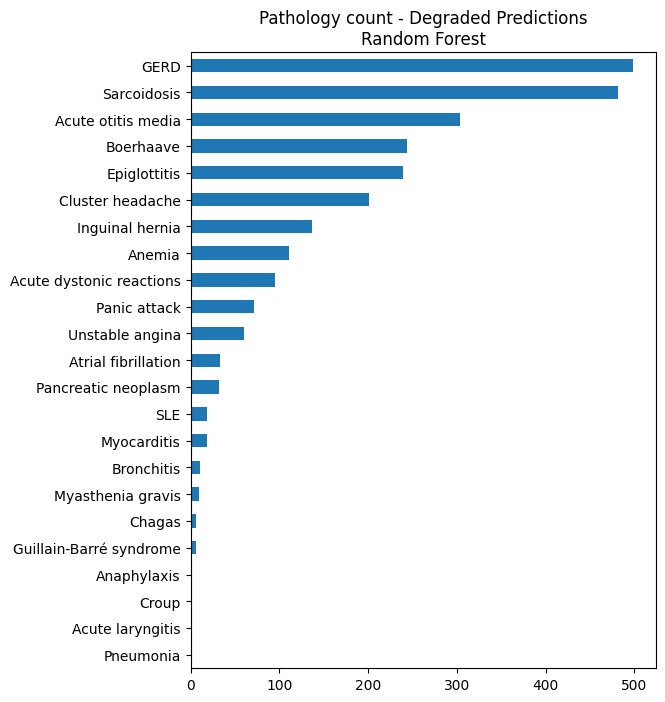

In [52]:
degraded_df["PATHOLOGY"].value_counts().sort_values().plot.barh(figsize=(6, 8))
plt.title("Pathology count - Degraded Predictions\nRandom Forest")
plt.savefig(f'{base_path}\\output\\questionnaire\\pathology_freq_degraded.jpg', bbox_inches='tight')

In [53]:
valid_df_questionnaire

,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
0,"['E_53', 'E_76', 'E_82', 'E_88', 'E_89', 'E_14...","['E_154', 'E_140', 'E_88', 'E_76', 'E_82', 'E_...",E_154,[]
1,"['E_50', 'E_53', 'E_66', 'E_75', 'E_111', 'E_1...","['E_171', 'E_111', 'E_75', 'E_157', 'E_177', '...",E_171,[]
2,"['E_50', 'E_53', 'E_88', 'E_91', 'E_94', 'E_12...","['E_53', 'E_91', 'E_181', 'E_144', 'E_50', 'E_...",E_53,[]
3,"['E_53', 'E_66', 'E_76', 'E_82', 'E_89', 'E_179']","['E_53', 'E_66', 'E_89', 'E_82', 'E_76', 'E_179']",E_53,[]
4,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148', 'E_210']",E_53,[]
...,...,...,...,...
132443,"['E_53', 'E_181', 'E_201']","['E_201', 'E_181', 'E_53']",E_201,[]
132444,"['E_53', 'E_66', 'E_67', 'E_151', 'E_217']","['E_151', 'E_67', 'E_217', 'E_53', 'E_66']",E_151,[]
132445,"['E_53', 'E_173', 'E_201', 'E_215']","['E_173', 'E_215', 'E_201', 'E_53']",E_173,[]
132446,"['E_53', 'E_65', 'E_91', 'E_190', 'E_194']","['E_91', 'E_53', 'E_190', 'E_194']",E_91,['E_65']


In [54]:
degraded_df = degraded_df.join(valid_df_questionnaire)
degraded_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
7,Acute otitis media,['Acute otitis media'],True,['GERD'],False,0.666667,"['E_53', 'E_114', 'E_201']","['E_201', 'E_53']",E_201,['E_114']
177,Acute otitis media,['Acute otitis media'],True,['Cluster headache'],False,0.666667,"['E_53', 'E_114', 'E_181']","['E_181', 'E_53']",E_181,['E_114']
189,Sarcoidosis,['Sarcoidosis'],True,['Myocarditis'],False,0.666667,"['E_43', 'E_53', 'E_66']","['E_53', 'E_66']",E_53,['E_43']
204,Cluster headache,['Cluster headache'],True,['Acute otitis media'],False,0.500000,"['E_53', 'E_127']",['E_53'],E_53,['E_127']
218,Pancreatic neoplasm,['Pancreatic neoplasm'],True,['Viral pharyngitis'],False,0.666667,"['E_53', 'E_188', 'E_201']","['E_201', 'E_53']",E_201,['E_188']
...,...,...,...,...,...,...,...,...,...,...
132225,GERD,['GERD'],True,['Acute otitis media'],False,0.666667,"['E_53', 'E_173', 'E_201']","['E_201', 'E_53']",E_201,['E_173']
132355,Sarcoidosis,['Sarcoidosis'],True,"['Stable angina', 'Pericarditis']",False,0.666667,"['E_53', 'E_66', 'E_74']","['E_53', 'E_66']",E_53,['E_74']
132371,Panic attack,['Panic attack'],True,['Possible NSTEMI / STEMI'],False,0.428571,"['E_50', 'E_53', 'E_66', 'E_111', 'E_157', 'E_...","['E_53', 'E_66', 'E_50']",E_53,"['E_157', 'E_177', 'E_171', 'E_111']"
132377,Boerhaave,['Boerhaave'],True,"['Myocarditis', 'Stable angina', 'Possible NST...",False,0.500000,"['E_53', 'E_66', 'E_210', 'E_211']","['E_66', 'E_53']",E_66,"['E_210', 'E_211']"


In [55]:
missed_evidences_per_disease = get_misses(degraded_df)

In [56]:
missed_evidences_per_disease["GERD"] # top 1 degrade

{'top_missed_evidences': {'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste in your mouth?': 375,
  'Do you have symptoms that get worse after eating?': 366,
  'Have you recently thrown up blood or something resembling coffee beans?': 130,
  'Have you recently had stools that were black (like coal)?': 124,
  'Are your symptoms worse when lying down and alleviated while sitting up?': 2},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 302,
  'Do you have a cough?': 197}}

In [57]:
missed_evidences_per_disease["Sarcoidosis"] # top 2 degrade

{'top_missed_evidences': {'Have you lost consciousness associated with violent and sustained muscle contractions or had an absence episode?': 305,
  'Have you noticed a diffuse (widespread) redness in one or both eyes?': 246,
  'Have you had any vaginal discharge?': 217},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 293,
  'Are you experiencing shortness of breath or difficulty breathing in a significant way?': 189}}

In [58]:
with open(f"{base_path}\\output\\error_analysis_questionnaire\\missed_evidences.json", "w") as outfile: 
    json.dump(missed_evidences_per_disease, outfile, indent=True)

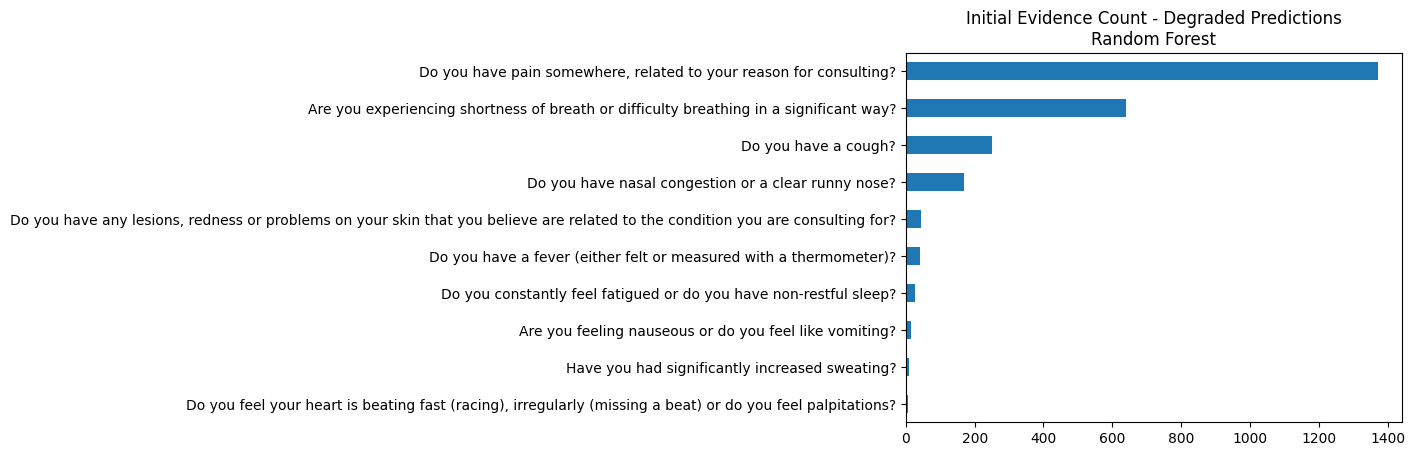

In [59]:
# most common initial evidence for the degrade - Do you have pain somewhere, related to your reason for consulting?, E_53
degraded_df.INITIAL_EVIDENCE.map(evidences_code_to_en).value_counts().sort_values().tail(10).plot.barh()
plt.title("Initial Evidence Count - Degraded Predictions\nRandom Forest")
plt.savefig(f'{base_path}\\output\\questionnaire\\initial_evidence_freq_degraded.jpg', bbox_inches='tight')

## Logistic Regression

In [60]:
valid_df_pred = pd.read_csv(f"{base_path}\\output\\error_analysis\\validation_logreg_df_all_patients.csv", index_col=False).drop(["Unnamed: 0"], axis=1)
valid_df_pred_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\validation_logreg_df_all_patients_questionnaire.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

In [61]:
valid_df_pred = valid_df_pred[["PATHOLOGY", "predicted_diagnosis", "is_matched"]]
valid_df_pred

,PATHOLOGY,predicted_diagnosis,is_matched
0,Anemia,['Anemia'],True
1,Panic attack,['Panic attack'],True
2,Influenza,['Influenza'],True
3,Anemia,['Anemia'],True
4,Boerhaave,['Boerhaave'],True
...,...,...,...
132443,Viral pharyngitis,['Viral pharyngitis'],True
132444,Acute pulmonary edema,['Acute pulmonary edema'],True
132445,GERD,['GERD'],True
132446,Epiglottitis,['Epiglottitis'],True


In [62]:
valid_df_pred_questionnaire = valid_df_pred_questionnaire[["predicted_diagnosis", "is_matched", "hit_rate"]]
valid_df_pred_questionnaire

,predicted_diagnosis,is_matched,hit_rate
0,['Anemia'],True,1.0
1,['Panic attack'],True,1.0
2,['Influenza'],True,1.0
3,['Anemia'],True,1.0
4,['Boerhaave'],True,1.0
...,...,...,...
132443,['Viral pharyngitis'],True,1.0
132444,['Acute pulmonary edema'],True,1.0
132445,['GERD'],True,1.0
132446,['Epiglottitis'],True,0.8


In [63]:
match_df = valid_df_pred.join(valid_df_pred_questionnaire.add_suffix("_questionnaire"))
match_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire
0,Anemia,['Anemia'],True,['Anemia'],True,1.0
1,Panic attack,['Panic attack'],True,['Panic attack'],True,1.0
2,Influenza,['Influenza'],True,['Influenza'],True,1.0
3,Anemia,['Anemia'],True,['Anemia'],True,1.0
4,Boerhaave,['Boerhaave'],True,['Boerhaave'],True,1.0
...,...,...,...,...,...,...
132443,Viral pharyngitis,['Viral pharyngitis'],True,['Viral pharyngitis'],True,1.0
132444,Acute pulmonary edema,['Acute pulmonary edema'],True,['Acute pulmonary edema'],True,1.0
132445,GERD,['GERD'],True,['GERD'],True,1.0
132446,Epiglottitis,['Epiglottitis'],True,['Epiglottitis'],True,0.8


In [64]:
pd.crosstab(index=match_df['is_matched'], columns=match_df['is_matched_questionnaire'])
# 13007 degraded predictions, 20 questions. previously correctly diagnosed but misdiagnosed using the questionnaire
# 2583 degraded, 30 questions

is_matched_questionnaire,False,True
is_matched,,
False,7370,0
True,2580,122498


In [65]:
degraded_df = match_df[(match_df['is_matched']==True) & (match_df['is_matched_questionnaire']==False)]

In [66]:
np.mean(degraded_df["hit_rate_questionnaire"])
# degraded predictions has low questionnaire hit rate, meaning for degraded predictions, relevant symptoms were not asked.

0.5157336655592469

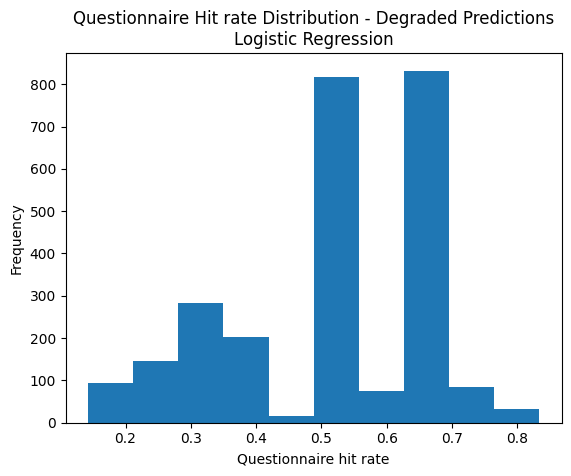

In [67]:
degraded_df["hit_rate_questionnaire"].plot.hist()
plt.title("Questionnaire Hit rate Distribution - Degraded Predictions\nLogistic Regression")
plt.xlabel("Questionnaire hit rate")
plt.savefig(f'{base_path}\\output\\questionnaire\\hit_rate_degraded_logreg.jpg', bbox_inches='tight')

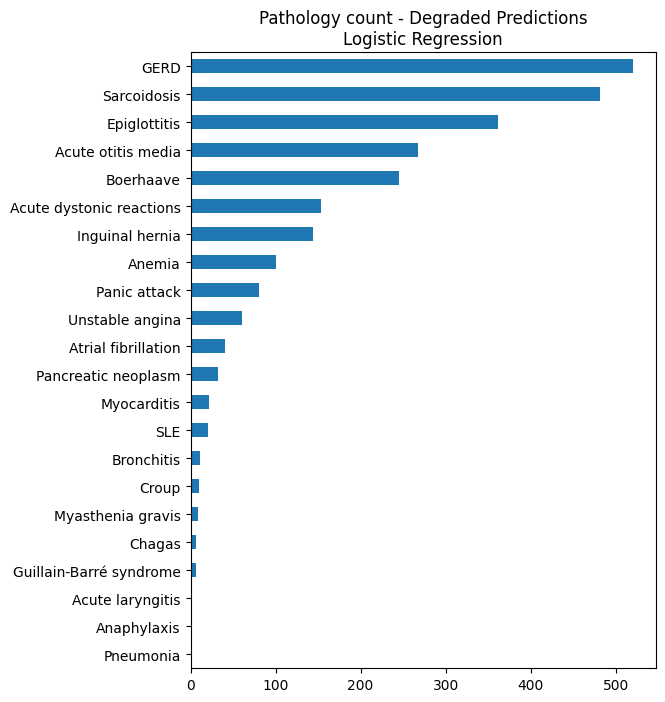

In [68]:
degraded_df["PATHOLOGY"].value_counts().sort_values().plot.barh(figsize=(6, 8))
plt.title("Pathology count - Degraded Predictions\nLogistic Regression")
plt.savefig(f'{base_path}\\output\\questionnaire\\pathology_freq_degraded_logreg.jpg', bbox_inches='tight')

In [69]:
valid_df_questionnaire

,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
0,"['E_53', 'E_76', 'E_82', 'E_88', 'E_89', 'E_14...","['E_154', 'E_140', 'E_88', 'E_76', 'E_82', 'E_...",E_154,[]
1,"['E_50', 'E_53', 'E_66', 'E_75', 'E_111', 'E_1...","['E_171', 'E_111', 'E_75', 'E_157', 'E_177', '...",E_171,[]
2,"['E_50', 'E_53', 'E_88', 'E_91', 'E_94', 'E_12...","['E_53', 'E_91', 'E_181', 'E_144', 'E_50', 'E_...",E_53,[]
3,"['E_53', 'E_66', 'E_76', 'E_82', 'E_89', 'E_179']","['E_53', 'E_66', 'E_89', 'E_82', 'E_76', 'E_179']",E_53,[]
4,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148', 'E_210']",E_53,[]
...,...,...,...,...
132443,"['E_53', 'E_181', 'E_201']","['E_201', 'E_181', 'E_53']",E_201,[]
132444,"['E_53', 'E_66', 'E_67', 'E_151', 'E_217']","['E_151', 'E_67', 'E_217', 'E_53', 'E_66']",E_151,[]
132445,"['E_53', 'E_173', 'E_201', 'E_215']","['E_173', 'E_215', 'E_201', 'E_53']",E_173,[]
132446,"['E_53', 'E_65', 'E_91', 'E_190', 'E_194']","['E_91', 'E_53', 'E_190', 'E_194']",E_91,['E_65']


In [70]:
degraded_df = degraded_df.join(valid_df_questionnaire)
degraded_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
7,Acute otitis media,['Acute otitis media'],True,['Viral pharyngitis'],False,0.666667,"['E_53', 'E_114', 'E_201']","['E_201', 'E_53']",E_201,['E_114']
51,Acute dystonic reactions,['Acute dystonic reactions'],True,['Bronchospasm / acute asthma exacerbation'],False,0.200000,"['E_66', 'E_128', 'E_168', 'E_193', 'E_205']",['E_66'],E_66,"['E_205', 'E_168', 'E_128', 'E_193']"
177,Acute otitis media,['Acute otitis media'],True,['Cluster headache'],False,0.666667,"['E_53', 'E_114', 'E_181']","['E_181', 'E_53']",E_181,['E_114']
189,Sarcoidosis,['Sarcoidosis'],True,['Stable angina'],False,0.666667,"['E_43', 'E_53', 'E_66']","['E_53', 'E_66']",E_53,['E_43']
218,Pancreatic neoplasm,['Pancreatic neoplasm'],True,['Viral pharyngitis'],False,0.666667,"['E_53', 'E_188', 'E_201']","['E_201', 'E_53']",E_201,['E_188']
...,...,...,...,...,...,...,...,...,...,...
132225,GERD,['GERD'],True,['Viral pharyngitis'],False,0.666667,"['E_53', 'E_173', 'E_201']","['E_201', 'E_53']",E_201,['E_173']
132355,Sarcoidosis,['Sarcoidosis'],True,['Stable angina'],False,0.666667,"['E_53', 'E_66', 'E_74']","['E_53', 'E_66']",E_53,['E_74']
132371,Panic attack,['Panic attack'],True,['Possible NSTEMI / STEMI'],False,0.428571,"['E_50', 'E_53', 'E_66', 'E_111', 'E_157', 'E_...","['E_53', 'E_66', 'E_50']",E_53,"['E_157', 'E_177', 'E_171', 'E_111']"
132377,Boerhaave,['Boerhaave'],True,['Stable angina'],False,0.500000,"['E_53', 'E_66', 'E_210', 'E_211']","['E_66', 'E_53']",E_66,"['E_210', 'E_211']"


In [71]:
missed_evidences_per_disease = get_misses(degraded_df)

In [72]:
missed_evidences_per_disease["GERD"] # top 1 degrade

{'top_missed_evidences': {'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste in your mouth?': 392,
  'Do you have symptoms that get worse after eating?': 385,
  'Have you recently thrown up blood or something resembling coffee beans?': 137,
  'Have you recently had stools that were black (like coal)?': 131},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 314,
  'Do you have a cough?': 207}}

In [73]:
missed_evidences_per_disease["Sarcoidosis"] # top 2 degrade

{'top_missed_evidences': {'Have you lost consciousness associated with violent and sustained muscle contractions or had an absence episode?': 305,
  'Have you noticed a diffuse (widespread) redness in one or both eyes?': 246,
  'Have you had any vaginal discharge?': 217},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 293,
  'Are you experiencing shortness of breath or difficulty breathing in a significant way?': 189}}

In [74]:
with open(f"{base_path}\\output\\error_analysis_questionnaire\\missed_evidences_logreg.json", "w") as outfile: 
    json.dump(missed_evidences_per_disease, outfile, indent=True)

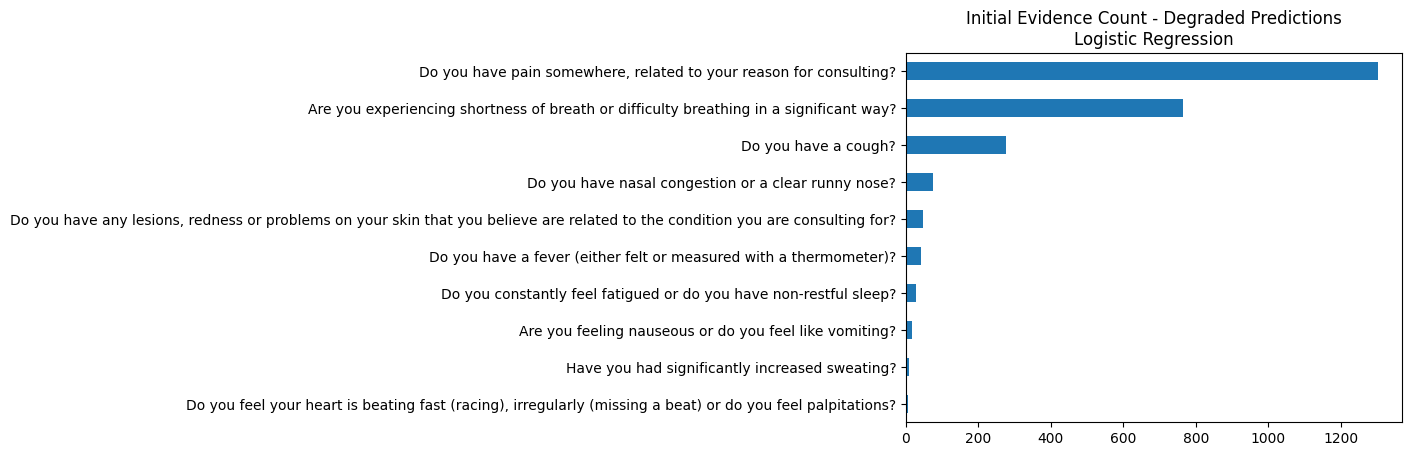

In [75]:
# most common initial evidence for the degrade - Do you have pain somewhere, related to your reason for consulting?, E_53
degraded_df.INITIAL_EVIDENCE.map(evidences_code_to_en).value_counts().sort_values().tail(10).plot.barh()
plt.title("Initial Evidence Count - Degraded Predictions\nLogistic Regression")
plt.savefig(f'{base_path}\\output\\questionnaire\\initial_evidence_freq_degraded_logreg.jpg', bbox_inches='tight')

## Decision Tree

In [76]:
valid_df_pred = pd.read_csv(f"{base_path}\\output\\error_analysis\\validation_dt_df_all_patients.csv", index_col=False).drop(["Unnamed: 0"], axis=1)
valid_df_pred_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\validation_dt_df_all_patients_questionnaire.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

In [77]:
valid_df_pred = valid_df_pred[["PATHOLOGY", "predicted_diagnosis", "is_matched"]]
valid_df_pred

,PATHOLOGY,predicted_diagnosis,is_matched
0,Anemia,['Anemia'],True
1,Panic attack,['Panic attack'],True
2,Influenza,['Influenza'],True
3,Anemia,['Anemia'],True
4,Boerhaave,['Boerhaave'],True
...,...,...,...
132443,Viral pharyngitis,['Acute otitis media'],False
132444,Acute pulmonary edema,['Acute pulmonary edema'],True
132445,GERD,['GERD'],True
132446,Epiglottitis,['Epiglottitis'],True


In [78]:
valid_df_pred_questionnaire = valid_df_pred_questionnaire[["predicted_diagnosis", "is_matched", "hit_rate"]]
valid_df_pred_questionnaire

,predicted_diagnosis,is_matched,hit_rate
0,['Anemia'],True,1.0
1,['Panic attack'],True,1.0
2,['Influenza'],True,1.0
3,['Anemia'],True,1.0
4,['Boerhaave'],True,1.0
...,...,...,...
132443,['Acute otitis media'],False,1.0
132444,['Acute pulmonary edema'],True,1.0
132445,['GERD'],True,1.0
132446,['Epiglottitis'],True,0.8


In [79]:
match_df = valid_df_pred.join(valid_df_pred_questionnaire.add_suffix("_questionnaire"))
match_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire
0,Anemia,['Anemia'],True,['Anemia'],True,1.0
1,Panic attack,['Panic attack'],True,['Panic attack'],True,1.0
2,Influenza,['Influenza'],True,['Influenza'],True,1.0
3,Anemia,['Anemia'],True,['Anemia'],True,1.0
4,Boerhaave,['Boerhaave'],True,['Boerhaave'],True,1.0
...,...,...,...,...,...,...
132443,Viral pharyngitis,['Acute otitis media'],False,['Acute otitis media'],False,1.0
132444,Acute pulmonary edema,['Acute pulmonary edema'],True,['Acute pulmonary edema'],True,1.0
132445,GERD,['GERD'],True,['GERD'],True,1.0
132446,Epiglottitis,['Epiglottitis'],True,['Epiglottitis'],True,0.8


In [80]:
pd.crosstab(index=match_df['is_matched'], columns=match_df['is_matched_questionnaire'])
# 2818 degraded predictions, 30 questions. previously correctly diagnosed but misdiagnosed using the questionnaire

is_matched_questionnaire,False,True
is_matched,,
False,21939,0
True,2818,107691


In [81]:
degraded_df = match_df[(match_df['is_matched']==True) & (match_df['is_matched_questionnaire']==False)]

In [82]:
np.mean(degraded_df["hit_rate_questionnaire"])
# degraded predictions has low questionnaire hit rate, meaning for degraded predictions, relevant symptoms were not asked.

0.5350531447497381

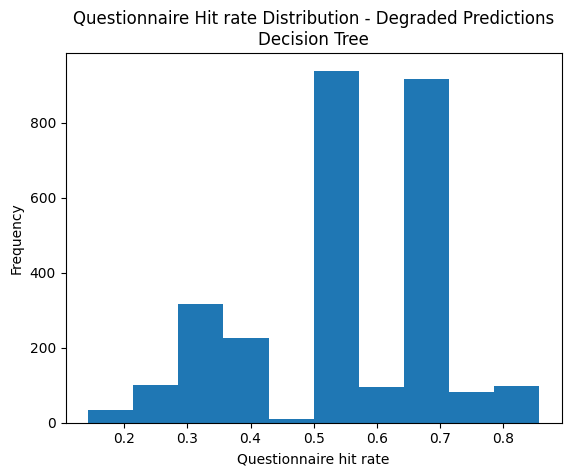

In [83]:
degraded_df["hit_rate_questionnaire"].plot.hist()
plt.title("Questionnaire Hit rate Distribution - Degraded Predictions\nDecision Tree")
plt.xlabel("Questionnaire hit rate")
plt.savefig(f'{base_path}\\output\\questionnaire\\hit_rate_degraded_dt.jpg', bbox_inches='tight')

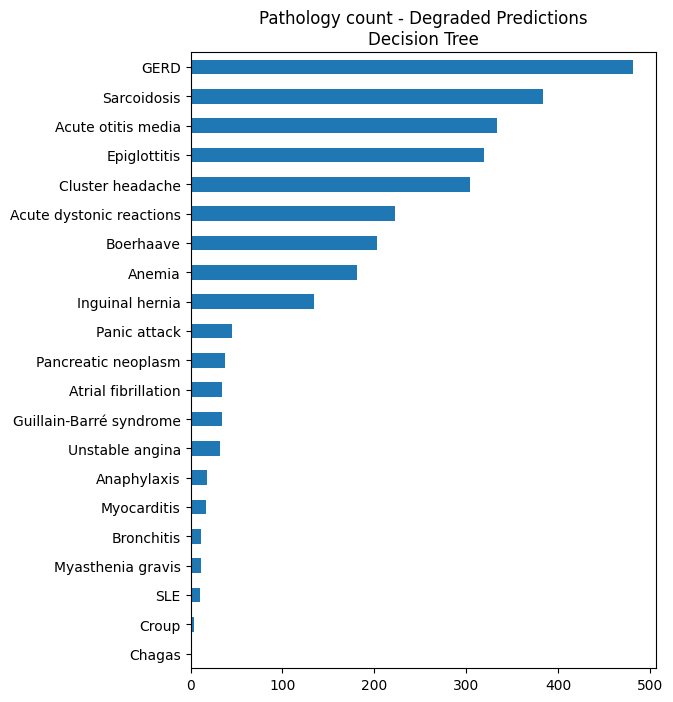

In [84]:
degraded_df["PATHOLOGY"].value_counts().sort_values().plot.barh(figsize=(6, 8))
plt.title("Pathology count - Degraded Predictions\nDecision Tree")
plt.savefig(f'{base_path}\\output\\questionnaire\\pathology_freq_degraded_dt.jpg', bbox_inches='tight')

In [85]:
valid_df_questionnaire

,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
0,"['E_53', 'E_76', 'E_82', 'E_88', 'E_89', 'E_14...","['E_154', 'E_140', 'E_88', 'E_76', 'E_82', 'E_...",E_154,[]
1,"['E_50', 'E_53', 'E_66', 'E_75', 'E_111', 'E_1...","['E_171', 'E_111', 'E_75', 'E_157', 'E_177', '...",E_171,[]
2,"['E_50', 'E_53', 'E_88', 'E_91', 'E_94', 'E_12...","['E_53', 'E_91', 'E_181', 'E_144', 'E_50', 'E_...",E_53,[]
3,"['E_53', 'E_66', 'E_76', 'E_82', 'E_89', 'E_179']","['E_53', 'E_66', 'E_89', 'E_82', 'E_76', 'E_179']",E_53,[]
4,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148', 'E_210']",E_53,[]
...,...,...,...,...
132443,"['E_53', 'E_181', 'E_201']","['E_201', 'E_181', 'E_53']",E_201,[]
132444,"['E_53', 'E_66', 'E_67', 'E_151', 'E_217']","['E_151', 'E_67', 'E_217', 'E_53', 'E_66']",E_151,[]
132445,"['E_53', 'E_173', 'E_201', 'E_215']","['E_173', 'E_215', 'E_201', 'E_53']",E_173,[]
132446,"['E_53', 'E_65', 'E_91', 'E_190', 'E_194']","['E_91', 'E_53', 'E_190', 'E_194']",E_91,['E_65']


In [86]:
degraded_df = degraded_df.join(valid_df_questionnaire)
degraded_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
7,Acute otitis media,['Acute otitis media'],True,['GERD'],False,0.666667,"['E_53', 'E_114', 'E_201']","['E_201', 'E_53']",E_201,['E_114']
37,Anemia,['Anemia'],True,"['Anemia', 'Stable angina']",False,0.600000,"['E_53', 'E_66', 'E_76', 'E_88', 'E_154']","['E_53', 'E_66', 'E_88']",E_53,"['E_76', 'E_154']"
142,Anemia,['Anemia'],True,"['Anemia', 'SLE']",False,0.857143,"['E_53', 'E_66', 'E_76', 'E_88', 'E_89', 'E_14...","['E_66', 'E_53', 'E_89', 'E_140', 'E_179', 'E_...",E_66,['E_76']
177,Acute otitis media,['Acute otitis media'],True,['Cluster headache'],False,0.666667,"['E_53', 'E_114', 'E_181']","['E_181', 'E_53']",E_181,['E_114']
204,Cluster headache,['Cluster headache'],True,['Acute otitis media'],False,0.500000,"['E_53', 'E_127']",['E_53'],E_53,['E_127']
...,...,...,...,...,...,...,...,...,...,...
132325,Acute dystonic reactions,['Acute dystonic reactions'],True,"['Myasthenia gravis', 'Acute dystonic reactions']",False,0.400000,"['E_66', 'E_172', 'E_180', 'E_192', 'E_193']","['E_66', 'E_172']",E_66,"['E_180', 'E_193', 'E_192']"
132355,Sarcoidosis,['Sarcoidosis'],True,"['Myocarditis', 'Stable angina', 'Possible NST...",False,0.666667,"['E_53', 'E_66', 'E_74']","['E_53', 'E_66']",E_53,['E_74']
132371,Panic attack,['Panic attack'],True,"['Unstable angina', 'Possible NSTEMI / STEMI']",False,0.428571,"['E_50', 'E_53', 'E_66', 'E_111', 'E_157', 'E_...","['E_53', 'E_66', 'E_50']",E_53,"['E_157', 'E_177', 'E_171', 'E_111']"
132377,Boerhaave,['Boerhaave'],True,"['Myocarditis', 'Stable angina', 'Possible NST...",False,0.500000,"['E_53', 'E_66', 'E_210', 'E_211']","['E_66', 'E_53']",E_66,"['E_210', 'E_211']"


In [87]:
missed_evidences_per_disease = get_misses(degraded_df)

In [88]:
missed_evidences_per_disease["GERD"] # top 1 degrade

{'top_missed_evidences': {'Do you have a burning sensation that starts in your stomach then goes up into your throat, and can be associated with a bitter taste in your mouth?': 363,
  'Do you have symptoms that get worse after eating?': 358,
  'Have you recently thrown up blood or something resembling coffee beans?': 123,
  'Have you recently had stools that were black (like coal)?': 122},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 284,
  'Do you have a cough?': 198}}

In [90]:
missed_evidences_per_disease["Sarcoidosis"] # top 1 degrade

{'top_missed_evidences': {'Have you lost consciousness associated with violent and sustained muscle contractions or had an absence episode?': 250,
  'Have you noticed a diffuse (widespread) redness in one or both eyes?': 201,
  'Have you had any vaginal discharge?': 176},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': 231,
  'Are you experiencing shortness of breath or difficulty breathing in a significant way?': 153}}

In [91]:
with open(f"{base_path}\\output\\error_analysis_questionnaire\\missed_evidences_dt.json", "w") as outfile: 
    json.dump(missed_evidences_per_disease, outfile, indent=True)

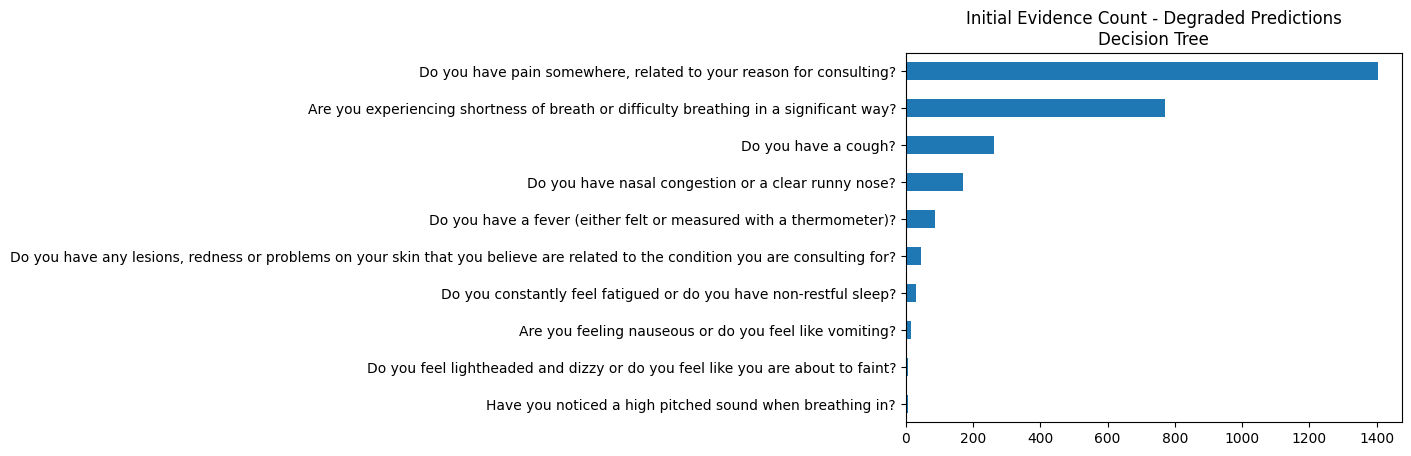

In [92]:
# most common initial evidence for the degrade - Do you have pain somewhere, related to your reason for consulting?, E_53
degraded_df.INITIAL_EVIDENCE.map(evidences_code_to_en).value_counts().sort_values().tail(10).plot.barh()
plt.title("Initial Evidence Count - Degraded Predictions\nDecision Tree")
plt.savefig(f'{base_path}\\output\\questionnaire\\initial_evidence_freq_degraded_dt.jpg', bbox_inches='tight')